# Strong Lensing Challenge - Multi-Class Classification 

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on exploring the potential of supervised models in identifying dark matter based on simulated strong lensing images with different substructure.

This is an example notebook for the Multi-Class Classification Challenge. In this notebook, we demonstrate a simple CNN model implemented using the PyTorch library to solve the task of multi-class classification of strong lensing images.

### Dataset

The Dataset consists of three classes, strong lensing images with no substructure, spherical substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

Link to the Dataset: https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view?usp=sharing

### Evaluation Metrics

* ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)   

The model performance will be tested on the hidden test dataset based on the above metrics.

### Instructions for using the notebook

1. Use GPU acceleration: (Edit --> Notebook settings --> Hardware accelerator --> GPU)
2. Run the cells: (Runtime --> Run all)

In [ ]:
# # Download Dataset
# !gdown http://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A
# !unzip -q dataset.zip

## Multi-Class Classification using a Supervised Model

### 1. Data Visualization and Preprocessing 

#### 1.1 Import all the necessary libraries

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage import transform
import torch.utils.data as tdata
from scipy import interp
from itertools import cycle
%matplotlib inline

#### 1.2 Preview the Data

In [ ]:
# Define the input paths
train_path1 = './dataset/train/no'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]
train_path2 = './dataset/train/sphere'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]
train_path3 = './dataset/train/vort'
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

print("# images in train dataset 1/no %0.0f" % len(os.listdir(train_path1)))
print("# images in train dataset 2/sphere %0.0f" % len(os.listdir(train_path2)))
print("# images in train dataset 3/vort %0.0f" % len(os.listdir(train_path3)))

# images in train dataset 1/no 10000
# images in train dataset 2/sphere 10000
# images in train dataset 3/vort 10000


------------------------
Cartesian coordinates
------------------------
Samples with no substructure: 


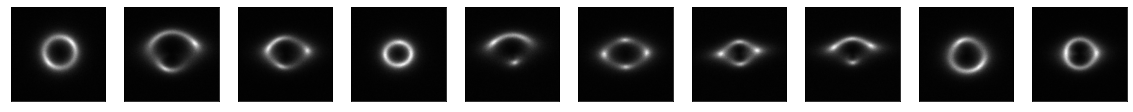

Samples with spherical substructure: 


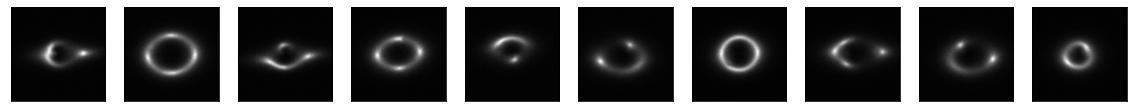

Samples with vortex substructure: 


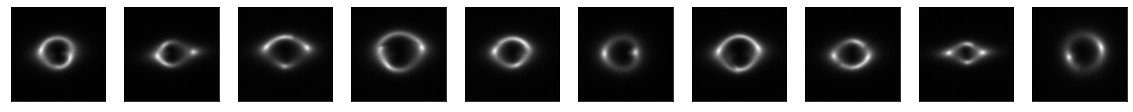

------------------------
Polar coordinates
------------------------
Samples with no substructure: 


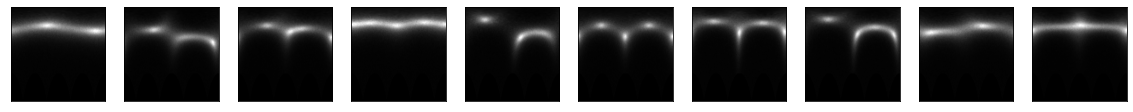

Samples with spherical substructure: 


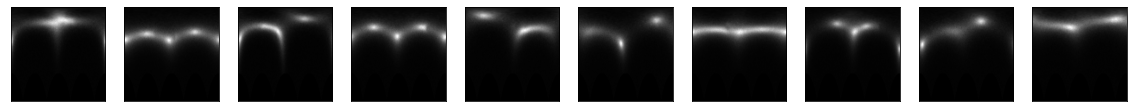

Samples with vortex substructure: 


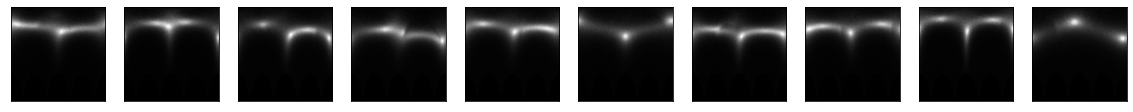

In [ ]:
# Number of samples to display per class
n = 10

# Plot the samples 
figsize=(20,20)

for doTransform in [False,True]:
    ### Resetting the figure and subplot
    plt.figure(figsize=figsize)
    i = 1

    print("------------------------")
    if doTransform:
        print("Polar coordinates")
    else:
        print("Cartesian coordinates")
    print("------------------------")
    print('Samples with no substructure: ')
    plt.rcParams['figure.figsize'] = figsize
    for image in train_files1[:n]:
        ax = plt.subplot(3,n,i)
        img=np.load(image).reshape(150,150)
        transformed_img=transform.warp_polar(img).T
        if doTransform:
            plt.imshow(transformed_img,aspect=transformed_img.shape[1]/transformed_img.shape[0], cmap='gray')
        else:
            plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i += 1
    plt.show()

    print('Samples with spherical substructure: ')
    plt.rcParams['figure.figsize'] = figsize
    for image in train_files2[:n]:
        ax = plt.subplot(3,n,i)
        img=np.load(image).reshape(150,150)
        transformed_img=transform.warp_polar(img).T
        if doTransform:
            plt.imshow(transformed_img,aspect=transformed_img.shape[1]/transformed_img.shape[0], cmap='gray')
        else:
            plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i += 1
    plt.show()

    print('Samples with vortex substructure: ')
    plt.rcParams['figure.figsize'] = figsize
    for image in train_files3[:n]:
        ax = plt.subplot(3,n,i)
        img=np.load(image).reshape(150,150)
        transformed_img=transform.warp_polar(img).T
        if doTransform:
            plt.imshow(transformed_img,aspect=transformed_img.shape[1]/transformed_img.shape[0], cmap='gray')
        else:
            plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i += 1
    plt.show()

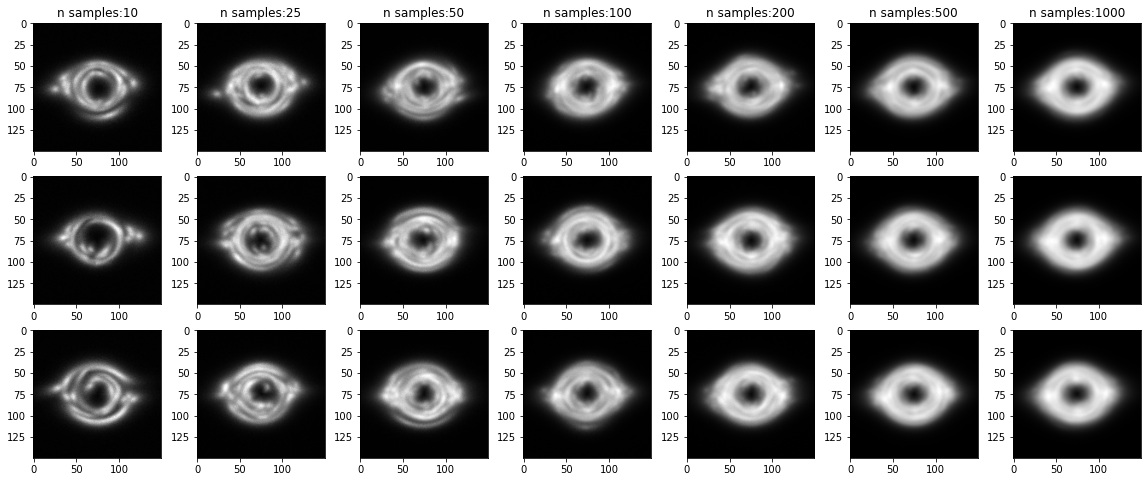

In [ ]:
### PLOTTING VARIATION IN EACH DATASET SINCE I AM NOT FAMILIAR WITH WHAT TO EXPECT
fig,axes=plt.subplots(3,7,figsize=(20,8))
train_files=[train_files1,train_files2,train_files3]
for i,n in enumerate([10,25,50,100,200,500,1000]):
    for j,train_file in enumerate(train_files):
        imgs=[]
        for image in random.sample(train_file,n):
            img=np.load(image).reshape(150,150)
            imgs.append(img)
        imgs=np.array(imgs)
        axes[j,i].imshow(imgs.std(axis=0), cmap='gray')
        if j==0:
            axes[j,i].set_title("n samples:%i"%n)

#### 1.3 Import Training and Validation Data

In [ ]:
# Set Batch Size
batch_size = 512

# Define Data Loaders
def npy_loader(path):
    #### DO NOT TRANSFORM
    sample = np.load(path)
    #### DO TRANSFORM
    # sample = np.load(path).reshape(150,150) # The input shape is actually [1,150,150] which contains extra axis. Delete it and put it back after transform
    # sample = transform.warp_polar(sample).T#[:,:210]
    # sample = sample[np.newaxis, :, :]
    ##################
    sample = torch.from_numpy(sample)
    return sample
    
train_data = torchvision.datasets.DatasetFolder(root='./dataset/train', loader=npy_loader, extensions='.npy')
print("Training Classes: " + str(train_data.class_to_idx))
train_data_loader = tdata.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_data = torchvision.datasets.DatasetFolder(root='./dataset/val', loader=npy_loader, extensions='.npy')
print("Validation Classes: " + str(val_data.class_to_idx))
val_data_loader = tdata.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


### 2. Training

#### 2.1 Defining a CNN Model

You may refer to this [article](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148) to learn about Convolutional Neural Networks (CNN)

In [ ]:
# Define the Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride = 2, padding = 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2, padding = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 0)
        self.linear1 = nn.Linear(3200, 126)
        self.linear2 = nn.Linear(126, 3)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.relu(x) #tanh orginally
        #print(x.shape)
        x = self.maxpool(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)
        x = self.conv3(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x) # Keep linear, softmax already included in loss function
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Loss Function
criteria = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

#### 2.2 Training the CNN Model

In [ ]:
# model.load_state_dict(torch.load("trained_classifier_dark_matter.h5"))

<All keys matched successfully>

In [ ]:
# chkpt="classifier_chkpts"
# os.system(f"rm -rf {chkpt}")
# os.system(f"mkdir {chkpt}")

0

In [ ]:
# Calculate the number of batches
n_batches_train = (len(train_files1)*3)/batch_size


# Train the model
n_epochs = 1500 # Number of Training Epochs
train_loss_array = []
train_accs_array = []
val_loss_array = []
val_accs_array = []
pbar = tqdm(range(1, n_epochs+1))
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0
    #### TRAINING
    for step, (x_tr, y_tr) in enumerate(train_data_loader):
        data = Variable(x_tr).type(torch.cuda.FloatTensor)
        if torch.cuda.is_available():
            data = data.cuda()
        labels = torch.tensor(y_tr, dtype=torch.long, device=device)
        optimizer.zero_grad()
        outputs = model(data)
        _, preds = torch.max(model(data).data, 1)
        correct = (preds == labels).float().sum()
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss
        train_acc += correct/data.shape[0]
    train_loss = train_loss/n_batches_train
    train_acc = train_acc/n_batches_train
    train_loss_array.append(train_loss)
    train_accs_array.append(train_acc)
        
    #### VALIDATION
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for step, (x_tr, y_tr) in enumerate(val_data_loader):
            data = Variable(x_tr).type(torch.cuda.FloatTensor)
            if torch.cuda.is_available():
                data = data.cuda()
            labels = torch.tensor(y_tr, dtype=torch.long, device=device)
            outputs = model(data)
            _, preds = torch.max(model(data).data, 1)
            correct = (preds == labels).float().sum()
            loss = criteria(outputs, labels)
            val_loss += loss
            val_acc += correct/data.shape[0]
    model.train()
    val_loss = val_loss/n_batches_train
    val_acc = val_acc/n_batches_train
    val_loss_array.append(val_loss)
    val_accs_array.append(val_acc)
    
    # Display the Training Stats
    pbar.set_postfix({ 'Training Loss': train_loss.item(), 'Training Acc': train_acc.item(), 
                       'Validation Loss': val_loss.item(), 'Validation Acc': val_acc.item() })
    
    if epoch%10==0 or epoch==(n_epochs-1):
        PATH=f"{chkpt}/chkpt_epoch{epoch}.pt"
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train loss': train_loss,
                'val loss': val_loss,
                'train acc': train_acc,
                'val acc': val_acc,
                }, PATH)

  0%|          | 0/1500 [00:00<?, ?it/s]

/tmp/ipykernel_855410/1414976011.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_tr, dtype=torch.long, device=device)
/tmp/ipykernel_855410/1414976011.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_tr, dtype=torch.long, device=device)


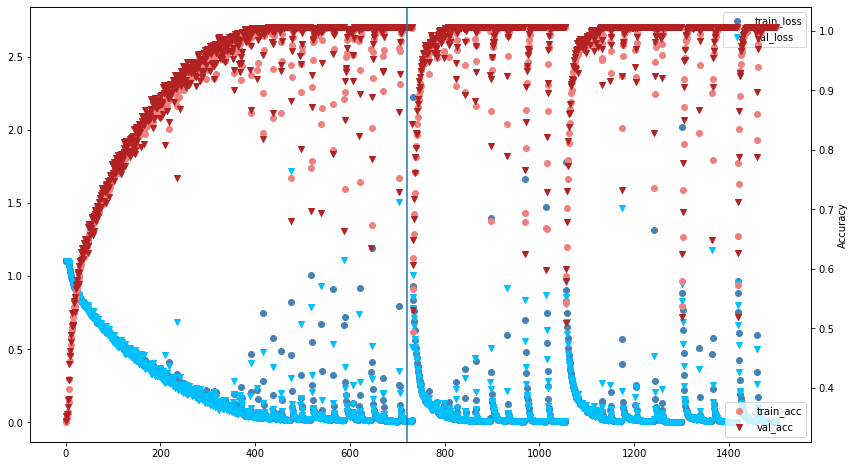

In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(range(n_epochs),torch.tensor(train_loss_array).numpy(),c="steelblue",marker='o',label="train_loss")
plt.scatter(range(n_epochs),torch.tensor(val_loss_array).numpy(),c="deepskyblue",marker='v',label="val_loss")
plt.legend()
ax=plt.twinx()
ax.scatter(range(n_epochs),torch.tensor(train_accs_array).numpy(),c='lightcoral',marker='o',label="train_acc")
ax.scatter(range(n_epochs),torch.tensor(val_accs_array).numpy(),c='firebrick',marker='v',label="val_acc")
plt.ylabel("Loss")
ax.set_ylabel("Accuracy")
plt.xlabel("Epoch")
plt.axvline(720)
ax.legend(loc=4)

### 3. Testing

In [ ]:
chosen_chkptch=720
chkpt="classifier_chkpts"
checkpoint = torch.load(f"{chkpt}/chkpt_epoch{chosen_chkptch}.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss=checkpoint['train loss']
val_loss=checkpoint['val loss']
train_acc=checkpoint['train acc']
val_acc=checkpoint['val acc']

#### 3.1 Testing the CNN Model on Validation Data

In [ ]:
y_score = []
y_test = []
for _, (x_ts, y_ts) in enumerate(val_data_loader):
    mini_val_data = Variable(x_ts).type(torch.cuda.FloatTensor)
    if torch.cuda.is_available():
        mini_val_data = mini_val_data.cuda()
    y_score.append(torch.nn.functional.softmax(model(mini_val_data), dim=1).cpu().detach().numpy())
    y_test.append(y_ts.cpu().detach().numpy())

y_score = np.concatenate(y_score)
y_score = np.asarray(y_score).reshape(-1,3)

y_test = np.concatenate(y_test)
y_val = np.asarray(y_test).reshape(-1)
y_val = label_binarize(y_val, classes=[0, 1, 2])

#### 3.2 Plotting the ROC Curve

You may refer to this [article](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) to learn about the ROC Curve

/tmp/ipykernel_2172649/2229237971.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


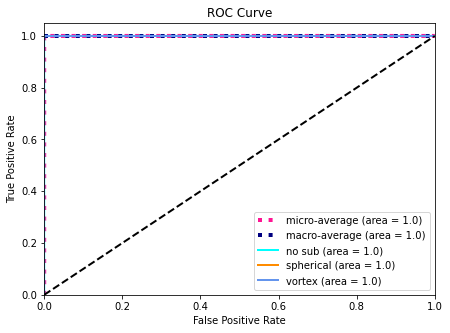

In [ ]:
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})

The AUC score is very low since we have trained a basic CNN model which is chosen for the sole purpose of demonstration. We expect your model to have a high AUC score.

## Submission Guidelines 

* You are required to submit a Google Colab Jupyter Notebook clearly showing your implementation along with the evaluation metrics (ROC curve, and AUC score) for the validation data.
* You must also submit the final trained model, including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. )
* You can use this example notebook as a template for your work. 

> **_NOTE:_**  You are free to use any ML framework such as PyTorch, Keras, TensorFlow, etc.

In [ ]:
# torch.save(model.state_dict(),'trained_classifier_dark_matter.h5')